### Лабораторная работа 5

#### Приближение функций

Прокопьев Григорий <br>
Вариант 21: 5.1.21, 5.2.4, 5.5.11, 5.8.2

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### Задача 5.1.21

Функция будет аппроксимироваться многочленом вида:
$$
P_m(x) = a_0 + a_1 x + \cdots + a_m x^m
$$

1) Задание векторов исходных данных:

In [2]:
x = np.arange(0, 3.25, 0.25)
y = np.array([-2.815, -2.18, -0.225, 1.722, 3.492, 3.31, 2.945, 1.449, 0.334, -1.906, -3.430, -2.983, 0.087])

2) Составление и решение нормальной системы наименьших квадратов:

Design matrix в нашем случае имеет вид:
$$A = \begin{pmatrix} 1 & x_1 & x_1^2 &\dots & x_1^m\\
                      1 & x_2 & x_2^2 &\dots & x_2^m\\
                      \vdots & \vdots&\vdots&&\vdots\\
                      1 & x_n & x_n^2 &\dots & x_n^m\\ \end{pmatrix}$$
Функция, которая ее возвращает:

In [4]:
def get_design_matrix(x, m):
    x_arr = np.array(x)
    A = np.empty((len(x), m+1))
    for i in range(m+1):
        A[:, i] = x_arr**i
    
    return A

Нормальная система для метода наименьших квадратов имеет вид:
$$ A^T A \vec\beta = A^T y, $$
где $\vec\beta$ $-$ вектор коэффициентов аппроксимирующего многочлена <br>

Функция, возвращающая решение системы:

In [5]:
def solve_normal_equations(A, y, residual = False):
    # residual = True: функция вернет сумму квадратов остатков
    y_arr = np.array(y)
    coeffs = np.linalg.solve(A.T @ A, A.T @ y_arr)
    if residual:
        res = A @ coeffs - y_arr
        return coeffs, res @ res
    else:
        return coeffs

При $residual = True$ функция вернет сумму квадратов остатков, т.е.
$ \sum_{k=1}^n \left( P_m(x_k) - y_k \right)^2 $

2.1) Нахождение коэффициентов многочленов $P_m, m = 0, 1, 2, \dots, 12$ из нормальной системы и вычисление соотвествующих им $\sigma_m$:

In [6]:
M = 12

coeffs_res = []
for m in range(M+1):
    coeffs_res.append( solve_normal_equations(get_design_matrix(x, m), y, residual=True) )

sigma = list(map(lambda c:  np.sqrt(c[1] / (len(x) - len(c[0]) + 1)), coeffs_res))

где: $ \sigma_m = \sqrt{\frac{1}{n - m} \sum_{k=1}^n \left( P_m(x_k) - y_k \right)^2} $

P.S. нет смысла брать $M \geq 13$, так как $n = 13$ и тогда $n - m \leq 0$ 

3) Гистограмма зависимости $\sigma_m$ от $m$:

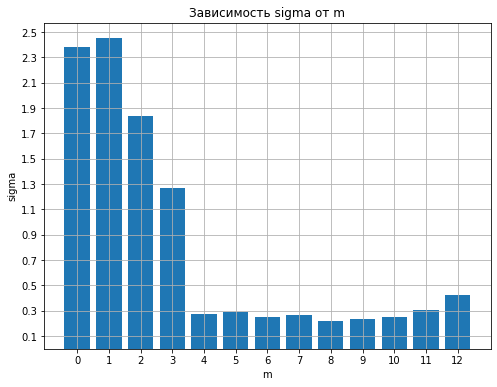

In [7]:
plt.figure(figsize=(8, 6))
plt.bar(list(range(M+1)), sigma)
plt.xticks(list(range(M+1)))
plt.yticks(list(np.arange(0.1, 2.7, 0.2)))
plt.xlabel('m')
plt.ylabel('sigma')
plt.title('Зависимость sigma от m')
plt.grid()
plt.show()

Как видно за оптимальную степень многочлена $m^*$ можно принять $m = 8$, так как далее $\sigma_m$ начинает возрастать

In [8]:
m_opt = 8

4) Графики получившихся многочленов:

In [9]:
coeffs = [c[0] for c in coeffs_res]

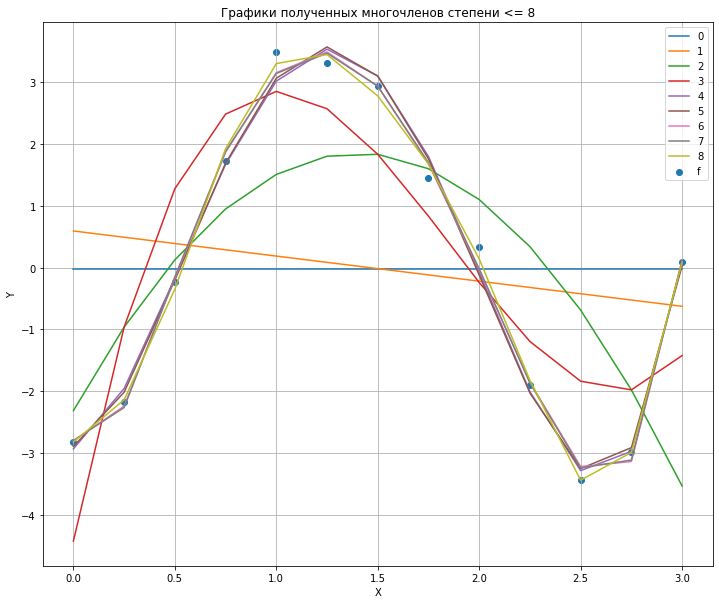

In [10]:
plt.figure(figsize=(12, 10))
plt.scatter(x, y, label = 'f')

for i, c in enumerate(coeffs[:m_opt+1]):
    poly = np.poly1d(c[::-1])
    plt.plot(x, poly(x), label = i)

    
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Графики полученных многочленов степени <= 8')
plt.grid()
plt.legend()
plt.show()

5) Решение задачи МНК через QR разложение:

In [11]:
coeffs_qr = []
for m in range(M+1):
    q, r = np.linalg.qr(get_design_matrix(x, m), mode='complete')
    r1 = r[:m+1]
    y1 = np.dot(q.T, y)[:m+1]
    coeffs_qr.append(np.linalg.solve(r1, y1))

Разница между коэффициентами, полученными с помощью решения нормальной системы МНК и QR разложения:

In [12]:
print ("{:<8} {:<16} {:<14} {:<10}".format('m','abs. diff.','res.','sigma'))
for i in range(len(coeffs)):
    # разница по модулю между коэффициентами:
    abs_diff = np.abs(coeffs_qr[i] - coeffs[i]).sum()
    # аппроксимирущий многочлен и остаток:
    poly = np.poly1d(coeffs_qr[i][::-1])
    res_qr = (poly(x) - y) @ (poly(x) - y)
    # СКО:
    sigma_qr = np.sqrt(res_qr/(len(x) - len(coeffs_qr[i]) + 1))
    
    print ("{:<2} {:16.9f} {:14.9f} {:14.9f}".format(i, abs_diff, res_qr, sigma_qr))

m        abs. diff.       res.           sigma     
0       0.000000000   74.027397077    2.386297375
1       0.000000000   72.150153912    2.452042582
2       0.000000000   37.190175323    1.838729189
3       0.000000000   16.141582532    1.270495279
4       0.000000000    0.690261854    0.276939996
5       0.000000000    0.669979500    0.289391495
6       0.000000343    0.433367895    0.248816598
7       0.000007361    0.429893225    0.267673067
8       0.000947815    0.236593906    0.217528806
9       0.077347169    0.217984604    0.233444107
10     48.048325713    0.183838917    0.247547246
11   5964.975982742    0.183487698    0.302892471
12 519391.972085928    0.000000000    0.000000067


Как видно, для полиномов степени $\geq 7$ абсолютная разница между коэффициентами становится существенной, в то время как остаток (разница между значениями многочлена и функции) и СКО (среднее квадратичное отклонение)  для QR метода становятся все меньше.

Сравнительные графики полученных полиномов:

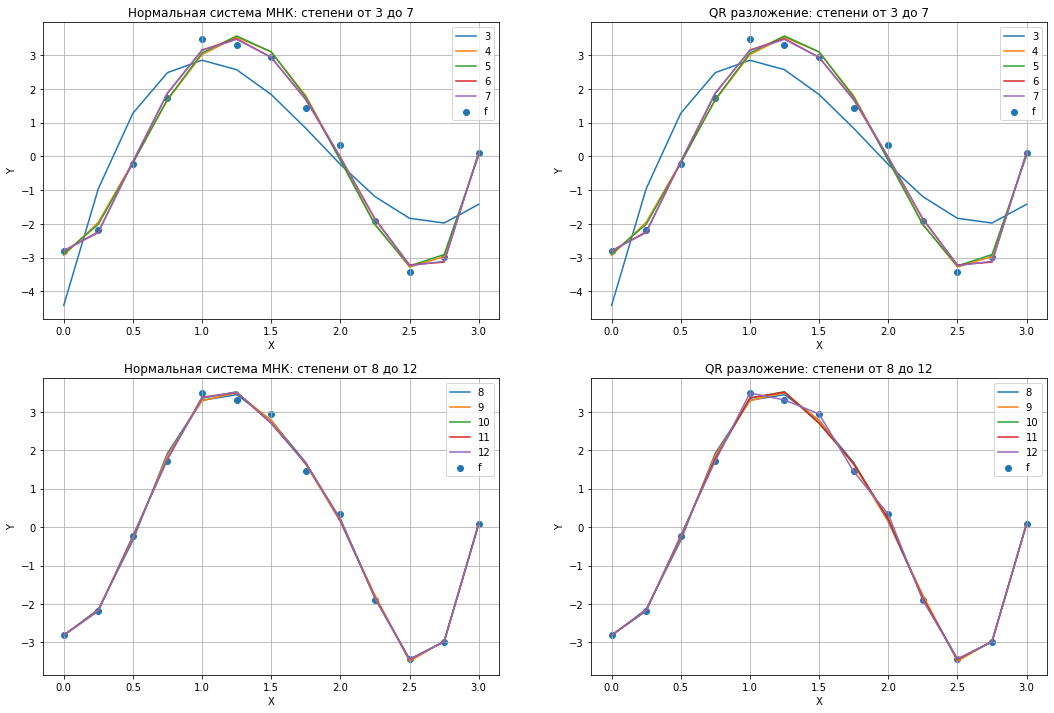

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))

ax[0, 0].scatter(x, y, label = 'f')
ax[0, 1].scatter(x, y, label = 'f')
ax[1, 0].scatter(x, y, label = 'f')
ax[1, 1].scatter(x, y, label = 'f')

for i, (c, c_qr) in enumerate(zip(coeffs, coeffs_qr)):
    if i < 3:
        continue
    poly = np.poly1d(c[::-1])
    poly_qr = np.poly1d(c_qr[::-1])
    if i <= 7:
        ax[0, 0].plot(x, poly(x), label=i)
        ax[0, 1].plot(x, poly_qr(x), label=i)
    else:
        ax[1, 0].plot(x, poly(x), label=i)
        ax[1, 1].plot(x, poly_qr(x), label=i)

for a in ax.flatten():
    a.legend()
    a.grid()
    a.set_xlabel('X')
    a.set_ylabel('Y')
    
ax[0, 0].set_title('Нормальная система МНК: степени от 3 до 7')
ax[0, 1].set_title('QR разложение: степени от 3 до 7')
ax[1, 0].set_title('Нормальная система МНК: степени от 8 до 12')
ax[1, 1].set_title('QR разложение: степени от 8 до 12')
plt.show()

Это видно и на графиках: многочлены более высоких степеней, полученные через QR разложение, аппроксимируют функцию лучше.

Ухудшение точности аппроксимации через решение нормальной системы МНК можно объяснить плохой обусловленностью design matrix:

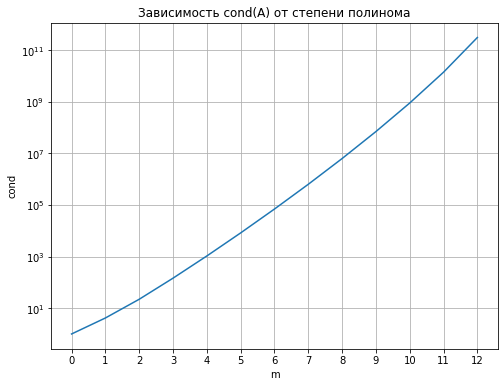

In [14]:
cond = []
for m in range(M+1):
    cond.append( np.linalg.cond(get_design_matrix(x, m)) )
    
plt.figure(figsize=(8,6))
plt.plot(list(range(M+1)), cond)
plt.xticks(list(range(M+1)))
plt.xlabel('m')
plt.ylabel('cond')
plt.title('Зависимость cond(A) от степени полинома')
plt.grid()
plt.yscale('log')

Зависимость экспоненциальная, в то время как число обусловленности для левой части нормальной системы МНК
:
$$ cond(A^T A) = cond(A)^2,$$
что, несомненно, несколько сказывается на точности аппроксимации.